In [1]:
################################################################################
"""
This is a Programming Project for Affective, Social Neuroscience (SoSe 2020).
This module provides the predictive modeling for level of immersion based on
 valence and arousal using the dataset" <http://>.

Those are requirement to run this module:
    - python :
    - keras
    - matplotlib
    - numpy
    - pandas
    - pingouin
    - seaborn
    - statsmodels
    - sklearn

This modules consists of three main part:
    - design a label
    - define the data of feature
    - model analysis

We are highly recommend to use the google colab to handle the code.

Authors : Andreea, Bati, JiHoon, and Sofia.
Last-modified : 11th September 2020
"""

! pip install pingouin

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import statsmodels.formula.api as smf
from keras.models import Model, Sequential
from keras import layers
from keras import Input
from scipy.stats import ttest_ind
from sklearn import svm, linear_model, metrics
sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

     |████████████████████████████████| 225kB 2.9MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.8-cp36-none-any.whl size=221688 sha256=80b1bfe10c4ed09791e81917a574f9a1055b065cfb7d0400b4842e396dab8f51
  Stored in directory: /root/.cache/pip/wheels/d6/9e/53/f885f73f29cf7c8cac3d8f4b1532bbfef2f5eb543946ac9055
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4961 sha256=10a288c6e2d28c94fb5a75dbdf927a36c71c9e336b42fef0f89f16dc7cdd04f7
  Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
  Created wheel for littleutils: filename=littleutils-0.2.2-cp36-none-any.whl size=7051 sha256=8cf4029defae29b072d8b4b5fec34b188988adc056e29a4f820da306860dcb69
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin outdated littleutils


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# for reproducibility
np.random.seed(26082020)

# upload the files at the google colab
from google.colab import files
uploaded = files.upload() # SENT_GROUP_INFO
uploaded2 = files.upload() # SENT_RATING

Saving SENT_GROUP_INFO.xlsx to SENT_GROUP_INFO.xlsx


Saving SENT_RATING_DATA.xlsx to SENT_RATING_DATA.xlsx


In [3]:
################################################################################
#              PART I: Exploratory Data Analysis and Data Cleaning
################################################################################
"""
# ATTENTION_CHECKS_COUNT_WRONG_ANSWERS
# ATTENTION_CHECKS_COUNT_CORRECT_ANSWERS
# DEG_TIME
# Can be an option of exclusion

# 14's readers response, literature reviews are pending
# KNOWLEDGE_OF_THE_STORY, fiction feeling hypothesis
# SOURCE_OF_KNOWLEDGE, fiction feeling hypothesis
# Can be an option of level of immersion

# DEVICE
# READING_FOR_PLEASURE
# LIKING_OF_READING
# Can be an option of both exclusion and immersion
"""
# Bring the candidate factors in the dataset
sg_factors = "B:E,J,AE:AI,BE,BF,CW:DJ,DM,DN,DP,EC,EE,EF,FN"

# Load the factors datasets
s_group = pd.read_excel('SENT_GROUP_INFO.xlsx', usecols = sg_factors)
s_rating = pd.read_excel('SENT_RATING_DATA.xlsx')

# Check the index of the senetence_group
print(s_group.columns)
print(s_rating.columns)
# Display the table
print(s_group)
print(s_rating)
s_group
s_rating

Index(['CASE', 'TEXT', 'CONDITION', 'QESTN_LANGUAGE', 'DEVICE',
       'BFI_EXTRAVERSION', 'BFI_AGREEABLENESS', 'BFI_CONSCIENTIOUSNESS',
       'BFI_NEUROTICISM', 'BFI_OPENNESS', 'PANAS_PA', 'PANAS_NA',
       'FOCUSING_OF_ATTENTION', 'TEXT_ABSORPTION', 'IMAGINABILITY',
       'SPATIAL_INVOLVEMENT', 'RECEPTION_TERMINATION', 'SUSPENSE',
       'EMOTIONAL_INVOLVEMENT', 'GENERAL_READING_ENJOYMENT', 'IDENTIFICATION',
       'PARASOCIAL_INTERACTION', 'COGNITIVE_INVOLVEMENT', 'THEMATIC_INTEREST',
       'ANALYTICAL_RECEPTION', 'EASE_OF_COGNITIVE_ACCESS',
       'ATTENTION_CHECKS_COUNT_WRONG_ANSWERS',
       'ATTENTION_CHECKS_COUNT_CORRECT_ANSWERS', 'KNOWLEDGE_OF_THE_STORY',
       'READING_FOR_PLEASURE', 'LIKING_OF_READING', 'SOURCE_OF_KNOWLEDGE',
       'DEG_TIME'],
      dtype='object')
Index(['CASE', 'TEXT', 'CONDITION', 'LANGUAGE', 'PAGE_TIME', 'SENTENCE_NUMBER',
       'AROUSAL_RATING', 'VALENCE_RATING'],
      dtype='object')
    CASE   TEXT  CONDITION  ... LIKING_OF_READING    SOURCE_

,CASE,TEXT,CONDITION,LANGUAGE,PAGE_TIME,SENTENCE_NUMBER,AROUSAL_RATING,VALENCE_RATING
0,12,PIPPI,SCRAMBLED,GER,17.0,1,3.0,4.0
1,12,PIPPI,SCRAMBLED,GER,19.0,2,3.0,5.0
2,12,PIPPI,SCRAMBLED,GER,7.0,3,2.0,6.0
3,12,PIPPI,SCRAMBLED,GER,5.0,4,3.0,4.0
4,12,PIPPI,SCRAMBLED,GER,16.0,5,1.0,7.0
...,...,...,...,...,...,...,...,...
12834,64,HARRY,COHERENT,ENG,8.0,121,4.0,2.0
12835,64,HARRY,COHERENT,ENG,10.0,122,3.0,4.0
12836,64,HARRY,COHERENT,ENG,7.0,123,4.0,5.0
12837,64,HARRY,COHERENT,ENG,8.0,124,2.0,5.0


In [4]:
################################################################################
#                              SENT_GROUP_INFO
################################################################################
# CASE                                       1 - 97
# TEXT                                       HARRY, PIPI
# CONDITION                                  COHERENT, SCRAMBLED
# QESTN_LANGUAGE                             ENG, GER
# DEVICE                                     LAPTOP/COMPUTER, SMARTPHONE
###################################BIG_FIVE#####################################
# BFI_EXTRAVERSION                           1.0 - 5.0
# BFI_AGREEABLENESS                          1.0 - 5.0
# BFI_CONSCIENTIOUSNESS                      1.0 - 5.0
# BFI_NEUROTICISM                            1.0 - 5.0
# BFI_OPENNESS                               1.0 - 5.0
######################################PANAS#####################################
# PANAS_PA                                   1.0 - 5.0
# PANAS_NA                                   1.0 - 5.0
# FOCUSING_OF_ATTENTION                      1.0 - 6.0
########################READER'S_EXPERIENCE#####################################
# FOCUSING_OF_ATTENTION                      1.0 - 6.0
# TEXT_ABSORPTION                            1.0 - 6.0
# IMAGINABILITY                              1.0 - 6.0
# SPATIAL_INVOLVEMENT                        1.0 - 6.0
# RECEPTION_TERMINATION                      1.0 - 6.0
# SUSPENSE                                   1.0 - 6.0
# EMOTIONAL_INVOLVEMENT                      1.0 - 6.0
# GENERAL_READING_ENJOYMENT                  1.0 - 6.0
# IDENTIFICATION                             1.0 - 6.0
# PARASOCIAL_INTERACTION                     1.0 - 6.0
# COGNITIVE_INVOLVEMENT                      1.0 - 6.0
# THEMATIC_INTEREST                          1.0 - 6.0
# ANALYTICAL_RECEPTION                       1.0 - 6.0
# EASE_OF_COGNITIVE_ACCESS                   1.0 - 6.0
################################################################################
# ATTENTION_CHECKS_COUNT_WRONG_ANSWERS       0 - 3
# ATTENTION_CHECKS_COUNT_CORRECT_ANSWERS     0 - 3
# KNOWLEDGE_OF_THE_STORY                     NO, VAGUELY, YES
# READING_FOR_PLEASURE                       1.0 - 4.0, 1 BAD
# LIKING_OF_READING                          1.0 - 5.0, 1 very unwillingly
# SOURCE_OF_KNOWLEDGE                        STRING
# DEG_TIME                                   > 100, BAD DATA
################################################################################

################################################################################
#                           SENT_RATING_INFO
################################################################################
# CASE                                       1 - 97
# TEXT                                       HARRY, PIPI
# CONDITION                                  COHERENT, SCRAMBLED
# LANGUAGE                                   ENG, GER
# PAGE_TIME                                  2 - 49883
# SENTENCE_NUMBER                            0
# AROUSAL_RATING                             351
# VALENCE_RATING                             351
################################################################################

# Demographic info on the countable columns
print(s_group.describe())
s_group.describe()
print("")
print(s_rating.describe())
s_rating.describe()

            CASE  BFI_EXTRAVERSION  ...  LIKING_OF_READING    DEG_TIME
count  97.000000         97.000000  ...          97.000000   97.000000
mean   49.000000          3.108247  ...           4.020619   17.257732
std    28.145456          1.046390  ...           0.935185   25.941552
min     1.000000          1.000000  ...           1.000000    0.000000
25%    25.000000          2.500000  ...           4.000000    5.000000
50%    49.000000          3.000000  ...           4.000000   11.000000
75%    73.000000          4.000000  ...           5.000000   18.000000
max    97.000000          5.000000  ...           5.000000  197.000000

[8 rows x 27 columns]

               CASE     PAGE_TIME  ...  AROUSAL_RATING  VALENCE_RATING
count  12839.000000  12488.000000  ...    12488.000000    12488.000000
mean      50.004985     38.060218  ...        3.290999        4.337764
std       28.305741    714.782177  ...        0.976644        1.544029
min        1.000000      2.000000  ...        1.00000

,CASE,PAGE_TIME,SENTENCE_NUMBER,AROUSAL_RATING,VALENCE_RATING
count,12839.000000,12488.000000,12839.000000,12488.000000,12488.000000
mean,50.004985,38.060218,66.948438,3.290999,4.337764
std,28.305741,714.782177,38.675491,0.976644,1.544029
min,1.000000,2.000000,1.000000,1.000000,1.000000
25%,25.000000,8.000000,34.000000,3.000000,3.000000
50%,51.000000,11.000000,67.000000,3.000000,4.000000
75%,75.000000,19.000000,100.000000,4.000000,6.000000
max,97.000000,49883.000000,142.000000,5.000000,7.000000


AxesSubplot(0.125,0.125;0.775x0.755)
BFI_OPENNESS:  0     5.0
1     5.0
2     4.0
3     4.5
4     2.5
     ... 
92    4.0
93    2.5
94    3.5
95    3.0
96    3.0
Name: BFI_OPENNESS, Length: 97, dtype: float64
PAGE_TIME:  0        17.0
1        19.0
2         7.0
3         5.0
4        16.0
         ... 
12834     8.0
12835    10.0
12836     7.0
12837     8.0
12838    17.0
Name: PAGE_TIME, Length: 12839, dtype: float64


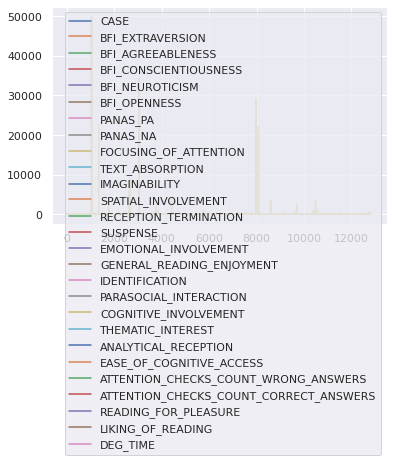

In [126]:
################################################################################
#                          Exploratory Data Analysis
################################################################################
"""
Exploartory Data Analysis
Please fill out why you decide to do further below steps based on which data.
Such as "the data distribution told us that we need to exclude that part.
"""
# ERD, Exploratory Data Analysis
print('s_group: ',s_group)
s_group.plot()
print('BFI_OPENNESS: ', s_group['BFI_OPENNESS'])
s_group['BFI_OPENNESS'].plot()
print('PAGE_TIME: ', s_rating['PAGE_TIME'])
s_rating['PAGE_TIME'].plot()

CASE                                       0
TEXT                                       0
CONDITION                                  0
QESTN_LANGUAGE                             0
DEVICE                                     0
BFI_EXTRAVERSION                           0
BFI_AGREEABLENESS                          0
BFI_CONSCIENTIOUSNESS                      0
BFI_NEUROTICISM                            0
BFI_OPENNESS                               0
PANAS_PA                                   0
PANAS_NA                                   0
FOCUSING_OF_ATTENTION                      0
TEXT_ABSORPTION                            0
IMAGINABILITY                              0
SPATIAL_INVOLVEMENT                        0
RECEPTION_TERMINATION                      0
SUSPENSE                                   0
EMOTIONAL_INVOLVEMENT                      0
GENERAL_READING_ENJOYMENT                  0
IDENTIFICATION                             0
PARASOCIAL_INTERACTION                     0
COGNITIVE_

'\nPlease proceed this step\n'

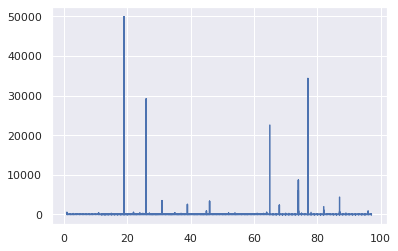

In [129]:
################################################################################
#                               Data cleaning
################################################################################
"""
COMMENT:
DEG_TIME, CASE: 34, 36 (>100)
ATTENTION_CHECKS_COUNT_CORRECT_ANSWERS: 96, 26, 34 (<2)
PAGE_TIME, CASE: 19, 26, 31, 39, 46, 65, 68, 74, 77, 82, 87 (> 1000)
b_list: 19, 26, 31, 34, 36, 39, 46, 65, 68, 74, 77, 82, 87, 96 (N=14)

Q. Exclude or not?
ATTENTION, 9, 13, 19, 22, 24, 30, 35, 43, 44, 48, 84 (==2)
"""
# SENT_GROUP_INFO
# Check the NaN in both the s_group and the s_rating
print(s_group.isnull().sum())
print(s_rating.isnull().sum())
plt.plot(s_rating['CASE'], s_rating['PAGE_TIME'])

# Save the CASE exclusion list
b_DEG = s_group.loc[s_group['DEG_TIME']>100]['CASE']
b_ATT = s_group.loc[s_group['ATTENTION_CHECKS_COUNT_CORRECT_ANSWERS']<2]['CASE']
b_PAG = s_rating.loc[s_rating['PAGE_TIME']>999]['CASE']

print(b_DEG)
print(b_ATT)
print(b_PAG)

# Concatenate the bad data list
b_list = pd.concat([b_DEG, b_ATT, b_PAG], axis = 0)
print(b_list)

# Delete the duplicates and make a list
b_list = b_list.drop_duplicates()
print(b_list)

# Exclusions using DEG_TIME, ATTENTION_CHECKS_COUNT_CORRECT_ANSWER
d_group = s_group.loc[s_group['DEG_TIME']<101]
a_group = d_group.loc[d_group['ATTENTION_CHECKS_COUNT_CORRECT_ANSWERS']>1]
print(a_group)
a_group

# Exclusions using PAGE_TIME
d_rating = s_rating.loc[s_rating['PAGE_TIME']<1000]
print(d_rating)
d_rating

# TASK #########################################################################
# Set the final sent_group_dataset, sent_rating_dataset

"""
Please proceed this step
"""
# HINT:
# Excluding the Ratings given by the two cases which are considered bad data
# good_data2=data2.loc[~(data2['CASE']==a)]
# good_data2=good_data2.loc[~(good_data2['CASE']==b)]
# data2=good_data2
# This is the work for 11-12th September

In [132]:
type(b_list)
print(type(b_list))
print(b_list)
b_case = list(b_list.values)
print(b_case)

<class 'list'>
33       34
35       36
25       26
95       96
1037     19
1344     65
1761     68
2622     74
3052     77
3766     82
4438     87
8593     31
9694     39
10485    46
Name: CASE, dtype: int64


TypeError: ignored

   CASE   TEXT  CONDITION  ...    SOURCE_OF_KNOWLEDGE DEG_TIME  IMMERSION
0     1  HARRY  SCRAMBLED  ...             BOOK, FILM       50   4.125000
1     2  HARRY  SCRAMBLED  ...             BOOK, FILM       15   5.017857
2     3  HARRY   COHERENT  ...  BOOK, FILM, AUDIOBOOK       13   5.303571
3     4  HARRY   COHERENT  ...             BOOK, FILM       18   4.065476
4     5  HARRY   COHERENT  ...                    NaN       14   2.327381
5     6  HARRY   COHERENT  ...                   FILM        8   4.071429
6     7  HARRY   COHERENT  ...             BOOK, FILM       10   4.488095
7     8  HARRY   COHERENT  ...  BOOK, FILM, AUDIOBOOK       13   5.375000
8     9  HARRY   COHERENT  ...                   BOOK       18   4.279762
9    10  HARRY   COHERENT  ...             BOOK, FILM        7   4.321429

[10 rows x 34 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

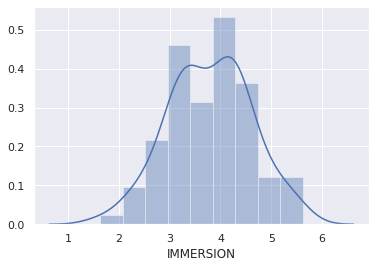

In [8]:
################################################################################
#               PART II: Design the label, level fo immersion
################################################################################
"""
Reivew the references are pending.

I. Can be applied the knowledge of the source, number of the source as count:
1, 2, 3

II. Design the level of immersion using multiplying:
log((1+value1)*(1+value2))

Check the caution code below:
"""
# Create the new column of 'IMMERSION'
a_group['IMMERSION'] = 0

# Sum the readers response
for i in range (14):
    a_group['IMMERSION'] += a_group.iloc[:,i+12]

# Using the mean of the reader's response
a_group['IMMERSION']=a_group['IMMERSION']/14
print(a_group.head(10))
sns.distplot(a_group["IMMERSION"])

FOCUSING_OF_ATTENTION
R2:  0.26929605675588963
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     33.54
Date:                Fri, 11 Sep 2020   Prob (F-statistic):           9.87e-08
Time:                        20:51:16   Log-Likelihood:                -97.730
No. Observations:                  93   AIC:                             199.5
Df Residuals:                      91   BIC:                             204.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

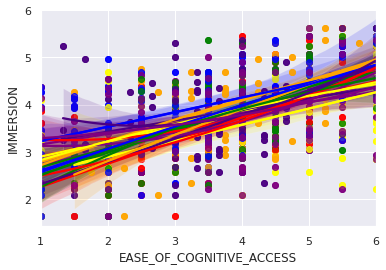

In [112]:
################################################################################
#         PART III: Statistical Analysis Immersion with other variable
################################################################################
"""
Test the correlation between IMMERSION and each of Reading Experience,
 and check the statistic significance
"""
# Statistical Analysises between Immersion and 14 Reading Experience: Mean case
# Using linear regression, oridnary least square

r_list = []
for i in range(14):
  r_list.append(a_group.columns[i+12])

def immersion_re_sa(r_list):
    for i, rr in enumerate(r_list):
        r_list = 'IMMERSION ~ '+ rr
        res = smf.ols(formula = r_list, data = a_group).fit()
        print(rr)
        print('R2: ', res.rsquared)
        print(res.summary())
        print('')

def immersion_re_pl(r_list):
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, rr in enumerate(r_list):    
        sns.regplot(x = rr, y="IMMERSION", data = a_group, color = color[i])

def immersion_re_pl2(r_list):
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, rr in enumerate(r_list):    
        sns.regplot(x = rr, y = "IMMERSION", data = a_group, color = color[i], order = 2)

immersion_re_sa(r_list)
immersion_re_pl(r_list)
immersion_re_pl2(r_list)

BFI_EXTRAVERSION
R2:  0.005263389150742426
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.4815
Date:                Fri, 11 Sep 2020   Prob (F-statistic):              0.490
Time:                        20:53:00   Log-Likelihood:                -112.07
No. Observations:                  93   AIC:                             228.1
Df Residuals:                      91   BIC:                             233.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

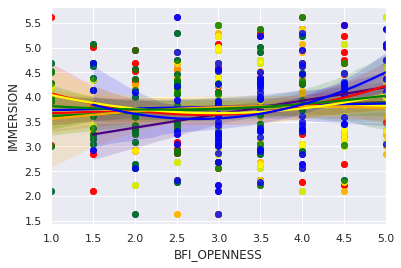

In [116]:
bfi_list = []
for i in range(5):
  bfi_list.append(a_group.columns[i+5])

def immersion_bfi_sa(bfi_list):
    for i, bfi in enumerate(bfi_list):
        bfi_list = 'IMMERSION ~ '+ bfi
        res = smf.ols(formula =bfi_list, data = a_group).fit()
        print(bfi)
        print('R2: ', res.rsquared)
        print(res.summary())
        print('')

def immersion_bfi_pl(bfi_list):
    color = ['red','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y="IMMERSION", data = a_group, color = color[i])

def immersion_bfi_pl2(bfi_list):
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y = "IMMERSION", data = a_group, color = color[i], order = 2)

immersion_bfi_sa(bfi_list)
immersion_bfi_pl(bfi_list)
immersion_bfi_pl2(bfi_list)

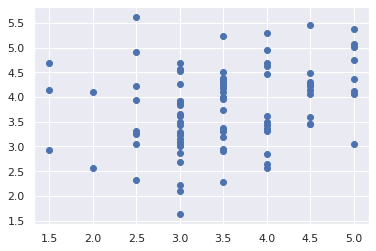

In [118]:
################################################################################
x = a_group['BFI_OPENNESS']
y = a_group['IMMERSION']
# print(x)
# print(y)
plt.scatter(x,y)

BFI_OPENESS
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     7.645
Date:                Fri, 11 Sep 2020   Prob (F-statistic):            0.00689
Time:                        11:31:12   Log-Likelihood:                -108.57
No. Observations:                  93   AIC:                             221.1
Df Residuals:                      91   BIC:                             226.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8327      0.356  

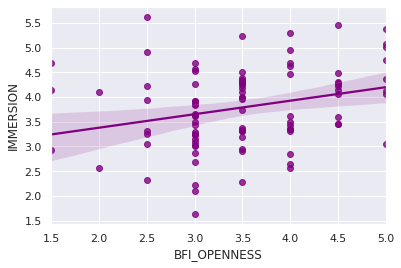

In [ ]:
################################################################################
# IMMERSION AND BFI OPENNESS
"""
7%, p-value < 0.05: candidate as the input data
"""
# Using linear regression, oridnary least square
res = smf.ols(formula='IMMERSION ~ BFI_OPENNESS', data = a_group).fit()
sns.regplot(x="BFI_OPENNESS", y="IMMERSION", data=a_group, color='purple')
print('BFI_OPENESS')
print(res.summary())

BFI_OPENESS


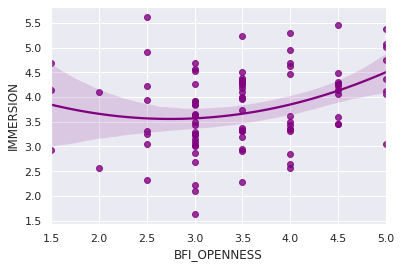

In [120]:
# TASK #########################################################################
# IMMERSION AND BFI OPENNESS
"""
Bati's task
"""
# Using non-linear, multiple regression test the statistic significance

#res = smf.gls(formula='IMMERSION ~ BFI_OPENNESS', data = a_group).fit()
sns.regplot(x="BFI_OPENNESS", y="IMMERSION",
            data = a_group, order = 2, color = 'purple')
#sns.lmplot(x="BFI_CONSCIENTIOUSNESS", y="IMMERSION", data=a_group, order=2)
print('BFI_OPENESS')
#print(res.summary())

In [ ]:
################################################################################
#                    PART IV: Model based data analysis
################################################################################
"""
"""
################################################################################
#                        Preprocess the dataset
################################################################################

# TASK##########################################################################
# Input: VALENCE, AROUSAL, and BFI_OPENESS
# Output : Immersion

# 1. Prepare label dataset
# 2. Prepare Input dataset,
# 3. Divide Harry and Pipi
# 4. Prepare the Training+Validation_set, Test_set

# This is the work for 11-12th September

In [ ]:
################################################################################
#             Run the model (formulation, estimation, evaluation)
################################################################################
"""
"""
################################################################################
# : Regression

################################################################################
# : XGBoost

################################################################################
# : SVM

################################################################################
# : Neural network (Shallow neural network)

# Define the model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# K-fold cross-validation
k = 4
num_val_samples = len(rain_data) // k
num_epochs = 100
all_mae_scores = []
for i in range(k):
    print('processing fold #:', i)
    val_data = train_data[i*num_val_samples: (i + 1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_smaples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs = num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_scores.append(mae_history)
    # val_mse, val_mae = model.evaluate(val_data, val_targets, vebose=0)
    # all_scores.append(val_mae)

# Validation MAE Visualization
plt.plot(range(1, len(average_mae_history)+1), average_mae_scores)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Final model
model = build()
model.fit(train, train_targets,
          epochs=100, batch_szie=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

"""
Grid search can be the option for hyepr-parameter tuning
"""
################################################################################
# : Transfer Learning: fine-tuning
# VCG16


################################################################################
# : CNN-RNN Multi Input Model

# valence
# arousal
# openess

input_valence = Input(shape=(None,), dtype='list')
embedded_valence = layers.Embedding(
    valence, 64)(input_valence)

# CNN-RNN
# econded_valence
    
input_arousal = Input(shape=(None,), dtype='list')
embedded_arousal = layers.Embedding(
    arousal, 64)(input_arousal)

# CNN-RNN
# encoded_arousal

input_openness = Input(shape=(None,), dtype='float')
embedded_openness = layers.Embedding(
    openess, 1((input_openess))

# Dense
# encoded_openness

concatenated = layers.concatenate([e_valence, e_arousal, e_openness], axis = -1)
answer = layers.

"""
k-fold, and data transformation work needed
"""
################################################################################
#                             Model prediction
################################################################################
"""
"""
# Select the appropriate model

In [ ]:
################################################################################
#                      PART V: Model application
################################################################################
"""
"""
################################################################################
# Transfer Learning
################################################################################